In [2]:
!pip install qiskit
!pip install qiskit_ibm_runtime
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/13

In [27]:
import math
from math import pi, asin, sqrt, floor
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler as Sampler

In [4]:
service = QiskitRuntimeService(channel="ibm_quantum",token="dd63143b2482be4578a9c8a3b57387eb937513750a212cc004f0cc09303cbf32f4a3702df59fee1b37d1f5338d6f15db61cf554c3d4f96d44cfb9845ff5560f0")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyiv'

In [19]:
def grover_oracle(marked_states): # implementing Zf Phase query gate
    if not isinstance(marked_states, list):
        marked_states = [marked_states]

    num_qubits = len(marked_states[0]) #if there are 3 bits so qc with 3 qubits and so on

    qc = QuantumCircuit(num_qubits)



    for target in marked_states:
        rev_target = target[::-1] # rev as qiskit uses little endiane

        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)] # finding starting qubit 0


        qc.x(zero_inds)

        qc.barrier(range(num_qubits))
        #Multi control CCZ gate
        qc.h(num_qubits - 1)
        qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        qc.h(num_qubits - 1)

        qc.barrier(range(num_qubits))

        qc.x(zero_inds)
    return qc

In [23]:
def diffusion_operator(num_qubits): # implementing HZorH gate or diffusion

    qc = QuantumCircuit(num_qubits)


    qc.h(range(num_qubits))    # H


    qc.x(range(num_qubits))    # X

    qc.barrier(range(num_qubits))

    # multicontrolled ccZ gate
    qc.h(num_qubits - 1)
    qc.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    qc.h(num_qubits - 1)

    qc.barrier(range(num_qubits))


    qc.x(range(num_qubits))    #  X gates reverting to og


    qc.h(range(num_qubits))    # H

    return qc

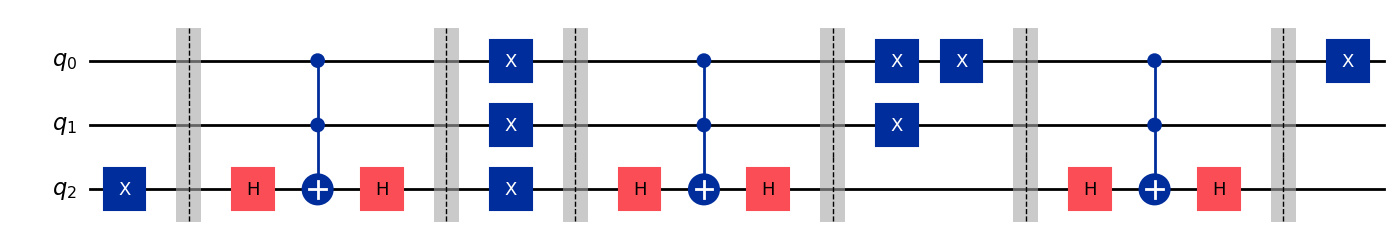

In [24]:
marked_states = ["011", "100","110"]
num_qubits = len(marked_states[0]) #if there are 3 bits so qc with 3 qubits and so on


oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

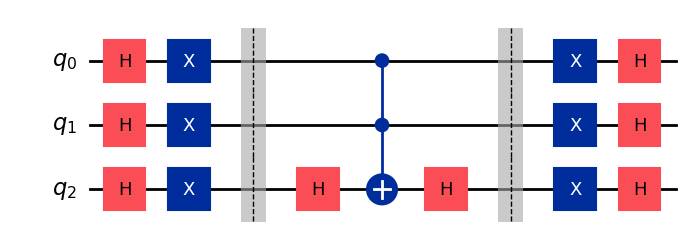

In [25]:
diffusion = diffusion_operator(num_qubits)
diffusion.draw(output="mpl", style="iqp")


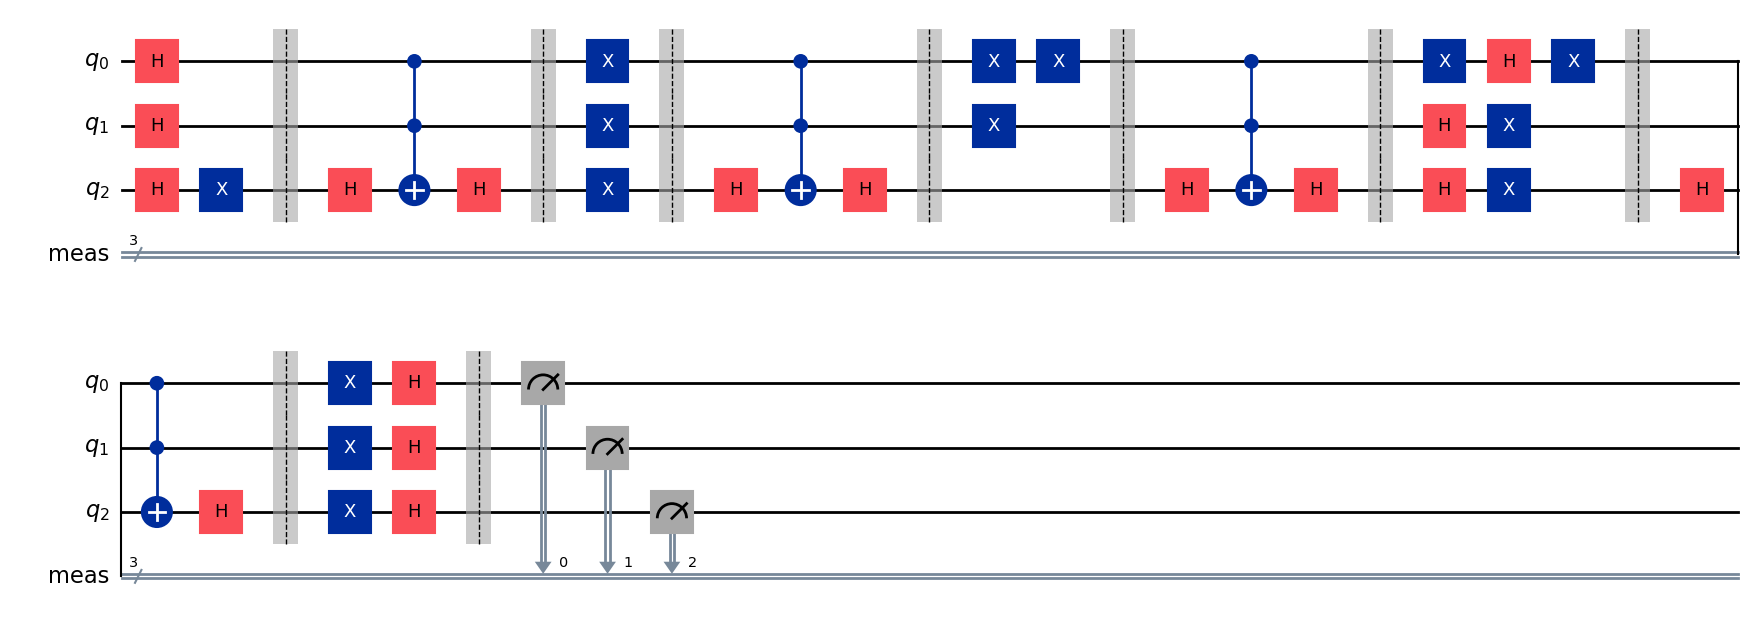

In [28]:
qc = QuantumCircuit(num_qubits)

# uniform superposition
qc.h(range(num_qubits))

num_iterations = floor(pi / (4 * asin(sqrt(len(marked_states) / 2**num_qubits))))

for _ in range(num_iterations): # running grover for the stipulated time
    qc.compose(oracle, inplace=True)
    qc.compose(diffusion, inplace=True)

qc.measure_all()
qc.draw(output="mpl", style="iqp")

Full Grover Circuit

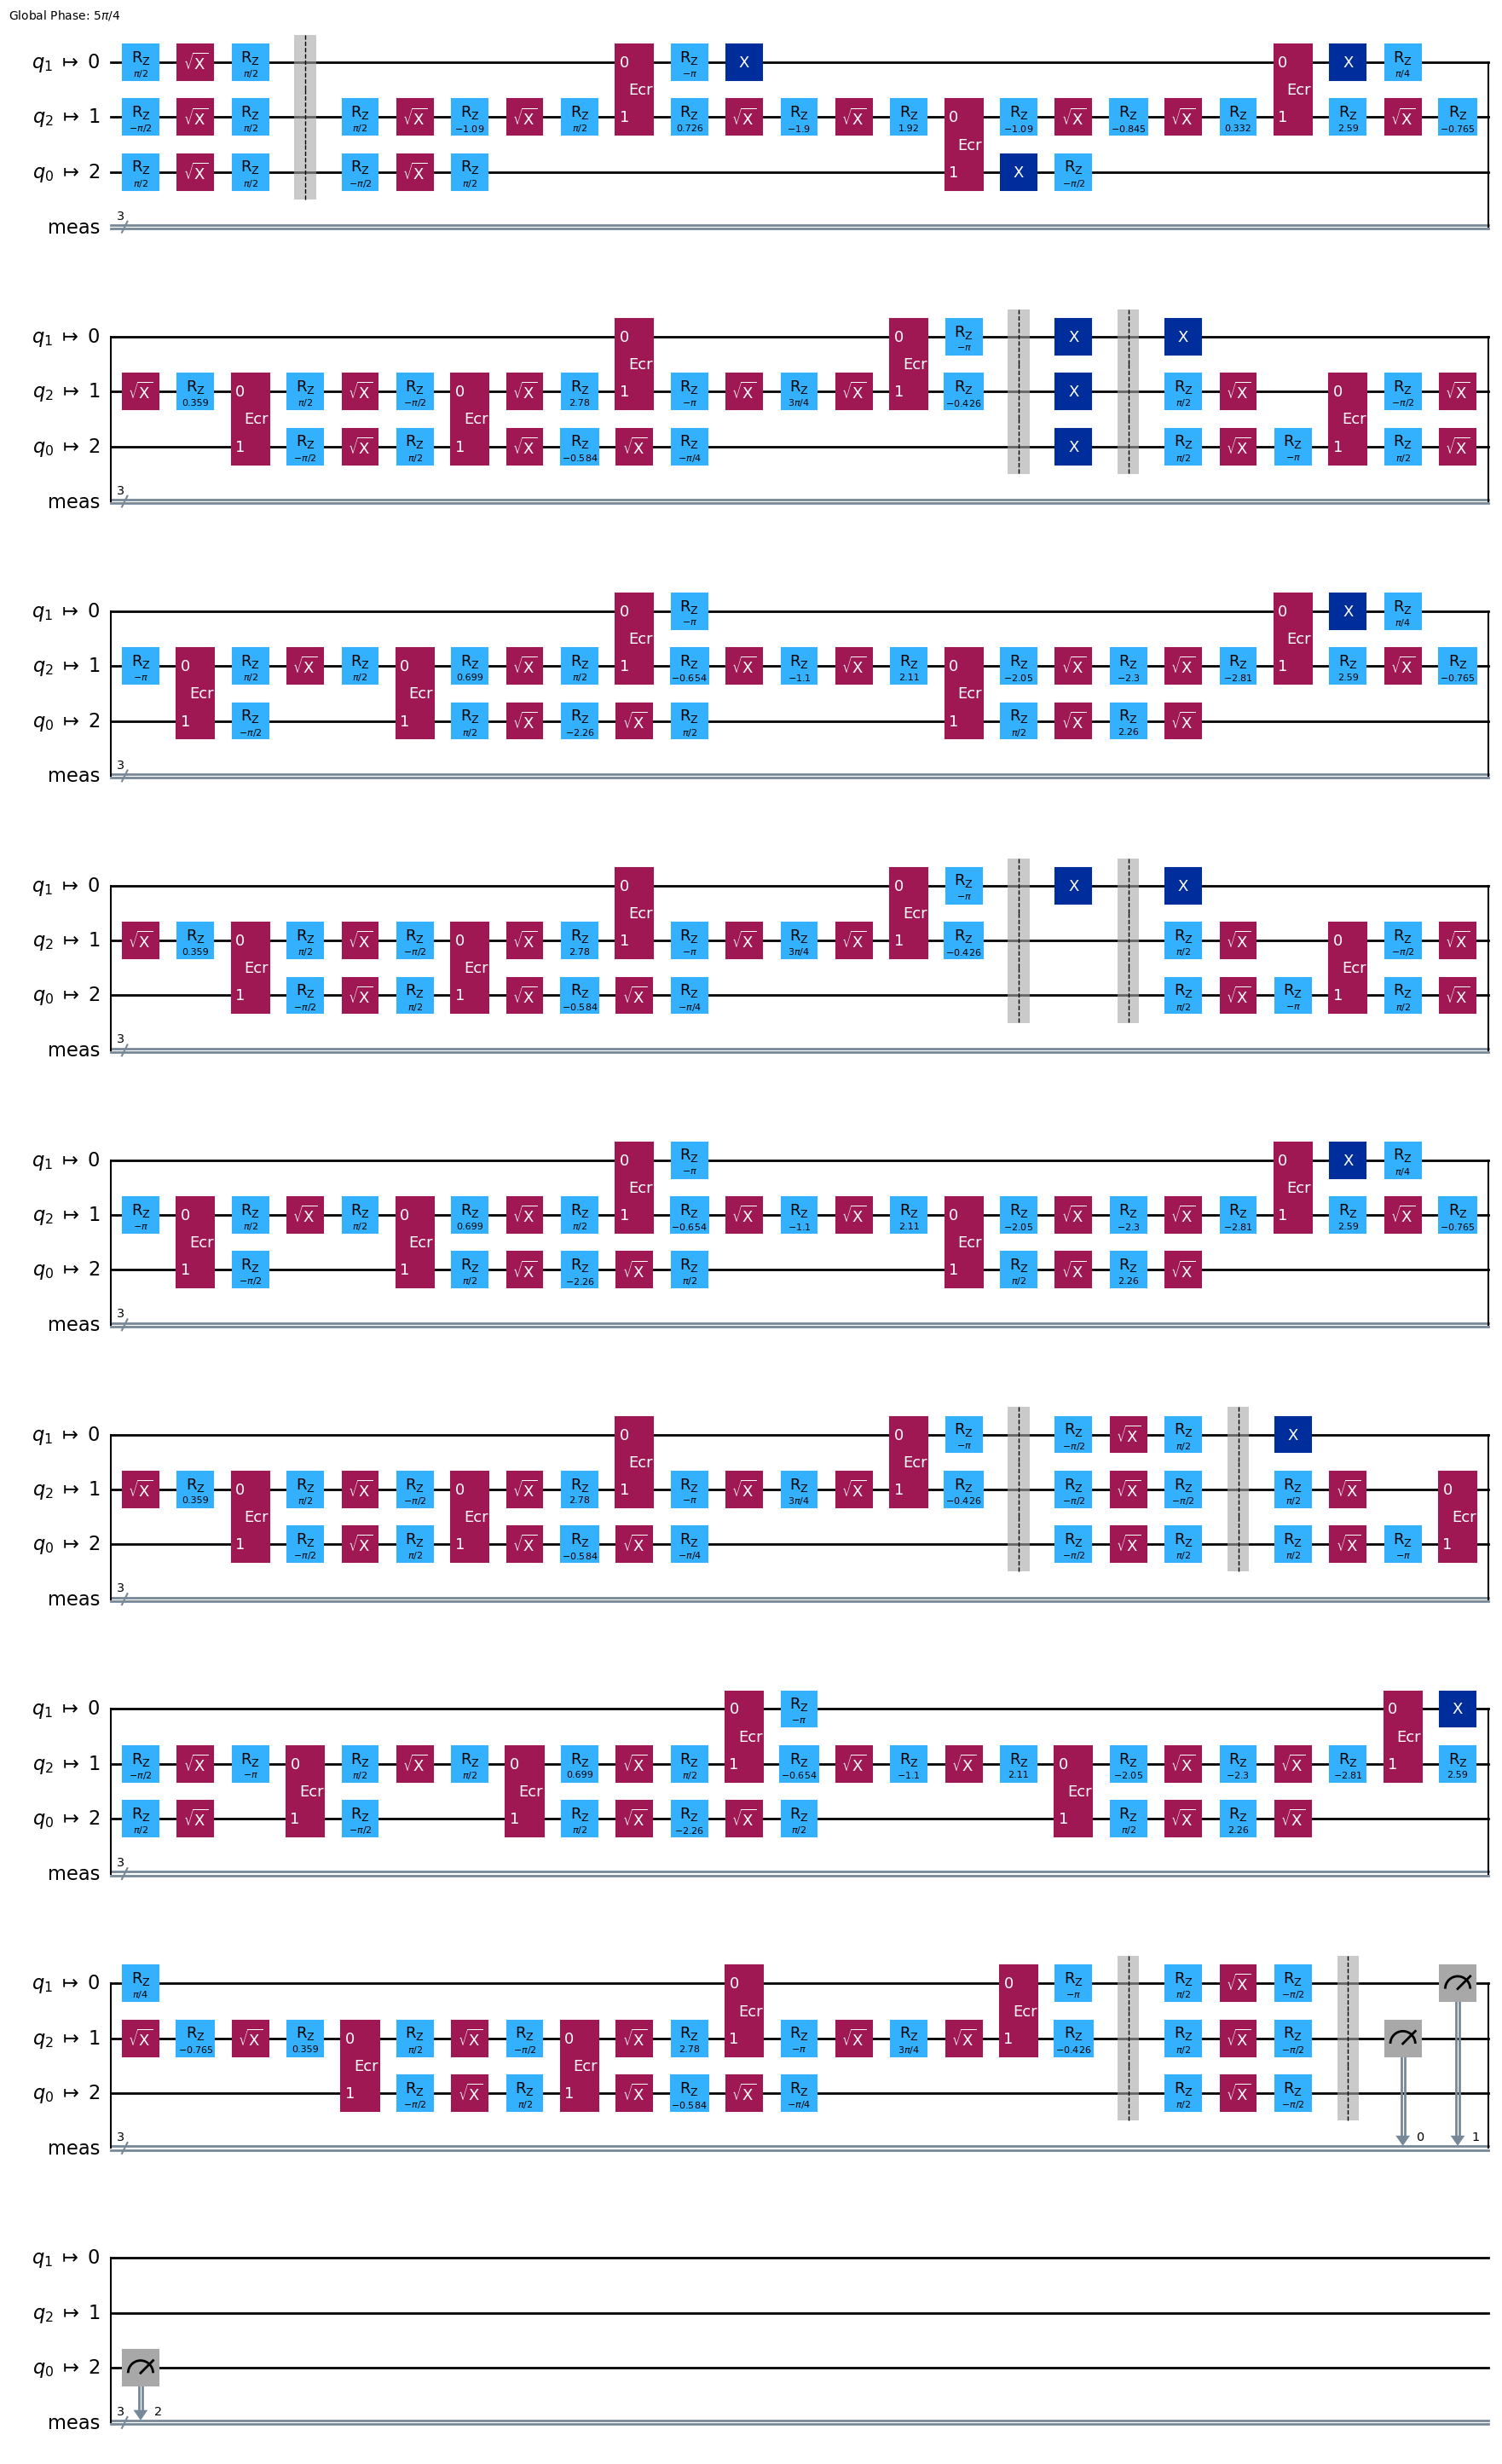

In [29]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [30]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1024
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

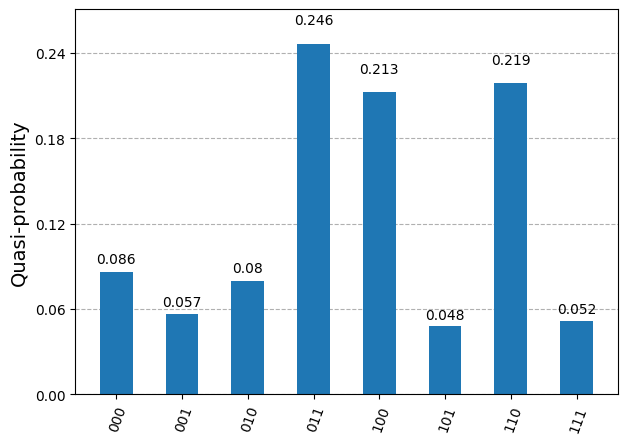

In [31]:
plot_distribution(dist)